In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

import kaleido

In [2]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

### assign_to_clusters
Ha lo scopo di assegnare ciascun dato in un insieme di dati a uno dei centroidi forniti

Per ogni punto nel dataset, viene calcolata la distanza euclidea tra quel punto e ciascun centroide presente in centroids.

La funzione np.argmin(distances) restituisce l'indice del centroide più vicino al punto, quindi l'indice del cluster a cui il punto dovrebbe essere assegnato.

L'indice del cluster assegnato al punto viene aggiunto alla lista clusters.

Output => la lista clusters che contiene gli indici dei cluster ai quali ciascun punto è stato assegnato.

In [3]:
def assign_to_clusters(data, centroids):
    clusters = []
    for point in data:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return clusters

### update_centroids

Aggiorna i centroidi dei cluster in base ai punti ad essi assegnati

Per ciascun cluster viene identificato l'insieme dei punti assegnati a quel cluster

Se tale insieme non è vuoto, il nuovo centroide sarà la media dei punti dei cluster

Il nuovo centroide viene quindi assegnato alla riga corrispondente nell'array new_centroids

    new_centroids:
    viene inizializzata una matrice vuota di zeri che verrà utilizzata per memorizzare i nuovi centroidi dei cluster dopo ogni iterazione dell'algoritmo KMeans. Ogni riga della matrice rappresenterà un centroide (infatti sulle righe abbiamo il numero di cluster), e ogni colonna rappresenterà una caratteristica dei dati



In [4]:
def update_centroids(data, clusters, num_clusters):
    new_centroids = np.zeros((num_clusters, data.shape[1]))
    for cluster in range(num_clusters):
        cluster_points = [data[i] for i in range(len(data)) if clusters[i] == cluster]
        if cluster_points:
            new_centroids[cluster] = np.mean(cluster_points, axis=0)
    return new_centroids

In [5]:
data = pd.read_csv('Country-data.csv')
df1 = data.copy()
columns_to_normalize = df1.columns.difference(['country'])
scaler = MinMaxScaler()

# Applica la normalizzazione solo sulle colonne numeriche
df1[columns_to_normalize] = scaler.fit_transform(df1[columns_to_normalize])

m1 = df1.drop(columns=['country']).values

In [6]:
num_clusters = 3
initial_centroids = np.array([m1[i] for i in np.random.choice(range(len(m1)), num_clusters, replace=False)])

max_iterations = 100
tolerance = 1e-4

centroids = initial_centroids
for i in range(max_iterations):
    old_centroids = centroids
    clusters = assign_to_clusters(m1, centroids)
    centroids = update_centroids(m1, clusters, num_clusters)
    if np.all(np.abs(centroids - old_centroids) < tolerance):
        break

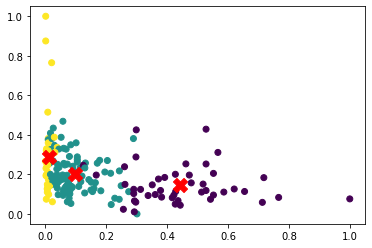

In [7]:
plt.scatter(m1[:, 0], m1[:, 1], c=clusters, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='red')
plt.show()

In [8]:
df1['Class'] = clusters
data['Class'] = clusters

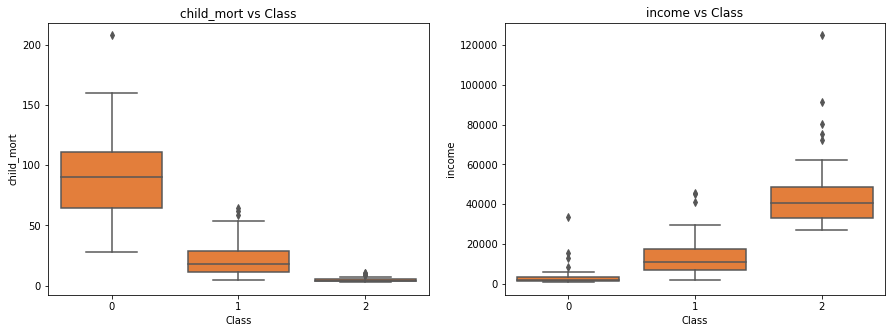

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [10]:
df1['Class'].loc[df1['Class'] == 0] = 'Help Needed'
df1['Class'].loc[df1['Class'] == 1] = 'Might Need Help'
df1['Class'].loc[df1['Class'] == 2] = 'No Help Needed'

In [11]:

fig = px.choropleth(df1[['country','Class']],
                    locationmode = 'country names',
                    locations = 'country',
                    title = 'Needed Help Per Country (World)',
                    color = df1['Class'],  
                    color_discrete_map = {'Help Needed':'Red',
                                        'No Help Needed':'Green',
                                        'Might Need Help':'Yellow'}
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

### silhouette_coefficient

Per ogni punto, calcola la distanza media "a" tra il punto attuale e gli altri punti nello stesso cluster e la distanza media "b" tra il punto attuale e i punti negli altri cluster. 

Il coefficiente di silhouette per il punto è quindi calcolato come la differenza tra "b" e "a", divisa per il massimo tra "a" e "b"

In [12]:
def silhouette_coefficient(data, clusters):
    num_points = len(data)
    silhouette_values = []

    for i in range(num_points):
        point = data[i]
        cluster = clusters[i]
        cluster_points = [data[j] for j in range(num_points) if clusters[j] == cluster]
        a = np.mean([euclidean_distance(point, other_point) for other_point in cluster_points if not np.array_equal(point, other_point)])

        other_clusters = set(range(len(centroids))) - {cluster}
        b_values = []
        for other_cluster in other_clusters:
            other_cluster_points = [data[j] for j in range(num_points) if clusters[j] == other_cluster]
            b_values.append(np.mean([euclidean_distance(point, other_point) for other_point in other_cluster_points]))

        b = min(b_values)
        silhouette = (b - a) / max(a, b)
        silhouette_values.append(silhouette)

    return (silhouette_values)

In [14]:
silhouette = silhouette_coefficient(m1, clusters)
print("Coefficiente di silhouette medio:", str(round(np.mean(silhouette), 4)))
print(silhouette)

Coefficiente di silhouette medio: 0.3427
[0.5195789586525151, 0.5342000607347709, 0.5052550317886347, 0.44892992919359515, 0.4665008146198823, 0.38500148115741517, 0.5560064838565649, 0.3139044963761614, 0.39314130188307855, 0.5046395451926171, 0.19423854352977257, 0.20682599564472692, 0.3969131246838255, 0.38305821173751775, 0.49040974363615436, 0.305369501645194, 0.5508496719069591, 0.48656383070943343, 0.5101720421745087, 0.3776293656728869, 0.28689141633264015, 0.1565870601128137, 0.3470102061496142, 0.09498069435134869, 0.4959297547779694, 0.541017865355679, 0.42636122020858425, 0.3752339458836389, 0.5018385439583161, 0.3708794576061347, 0.5176535169566555, 0.44934162214762685, 0.4972508994737216, 0.35439708264177194, 0.5166294050098635, 0.45299736516071615, 0.35991585542436866, 0.5093644875867195, 0.2207504010410803, 0.2562518099662872, 0.5065811628268851, 0.3590125868787618, -0.03132929901689182, -0.16694382530593485, 0.403744783856584, 0.546570246066763, 0.5020127480386946, 0.4

Plot delle silhouettes

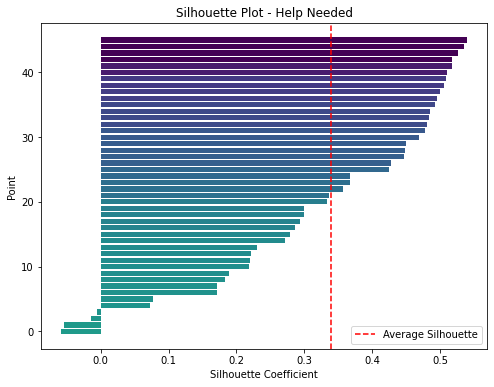

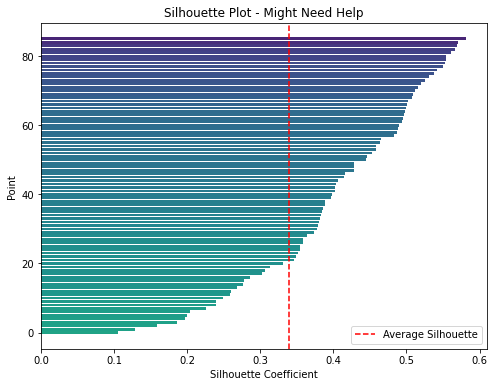

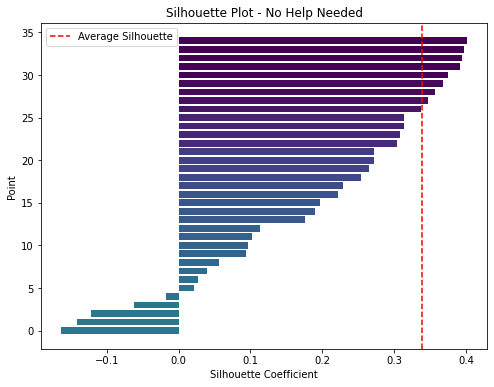

In [ ]:
# Calcola i valori di silhouette per ogni punto
silhouette_values = []
for i in range(len(m1)):
    point = m1[i]
    cluster = clusters[i]
    cluster_points = [m1[j] for j in range(len(m1)) if clusters[j] == cluster]
    a = np.mean([euclidean_distance(point, other_point) for other_point in cluster_points if not np.array_equal(point, other_point)])
    
    other_clusters = set(range(num_clusters)) - {cluster}
    b_values = []
    for other_cluster in other_clusters:
        other_cluster_points = [m1[j] for j in range(len(m1)) if clusters[j] == other_cluster]
        b_values.append(np.mean([euclidean_distance(point, other_point) for other_point in other_cluster_points]))
    
    b = min(b_values)
    silhouette = (b - a) / max(a, b)
    silhouette_values.append(silhouette)

# Ordina i punti in base ai valori di silhouette e plotta i barplot
sorted_indices = np.argsort(silhouette_values)[::-1]

for cluster in range(num_clusters):
    cluster_indices = [i for i in sorted_indices if clusters[i] == cluster]
    cluster_silhouette_values = [silhouette_values[i] for i in cluster_indices]
    
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(cluster_indices)), cluster_silhouette_values[::-1], color=plt.cm.viridis(cluster_silhouette_values))
    plt.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Point")
    plt.title(f"Silhouette Plot - {df1['Class'].unique()[cluster]}")
    plt.legend()
    plt.show()